# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


Le projet a été préparé par Gabriel Gobeil, associé de recherche à Polytechnique Montréal.

---
# Projet A2022 : Récolte des cerfs de Virginie


La description du projet est disponible à l'adresse suivante : https://www.kaggle.com/t/23b6d8c44f1247c78e19a6a902f804af

Ce calepin Jupyter de base permet de charger et de nettoyer les données fournies. La dernière section détaille la génération du fichier des prédictions afin de le soumettre sur Kaggle dans le bon format.

### Données

Dans un premier temps, vous devrez récupérer les données sur Kaggle. Les fichiers disponibles sont les suivants :
- recolte.csv
- permis.csv
- meteo.csv
- essence.csv
- test.csv

**Déposez ces fichiers dans un dossier nommé *data* dans le répertoire de ce calepin.**

Le fichier *recolte.csv* contient les statistiques de chasse au cerf de Viriginie. On y retrouve le nombre de cerfs mâles adultes récoltés annuellement dans certaines zones de chasse du Québec, listé selon le type d'engin utilisé.

Le fichier *permis.csv* contient des informations sur le nombre de permis de chasse aux cerfs de Virginie alloués aux résidents et non-résidents de 1999 à 2020.

Le fichier *meteo.csv* contient certaines variables météorologiques enregistrées à la station Montréal-Trudeau de 1999 à 2021 :
- Mean Temp (°C)	
- Total Rain (mm)	
- Total Snow (cm)	
- Snow on Grnd (cm)

Le fichier *essence.csv* contient des informations sur le prix de détail moyen par mois de l'essence pour Québec et Montréal de 1999 à 2021. Des renseignements additionnels sur les données sont disponibles à l'adresse suivante : https://www150.statcan.gc.ca/t1/tbl1/fr/cv.action?pid=1810000101

Le fichier *test.csv* contient les zones de chasse pour lesquels vous devez prédire le nombre de cerfs mâles adultes récoltés pour l'année 2021, peu importe l'engin de chasse utilisé. La qualité de vos prédictions sera ensuite évaluée lorsque vous les téléverserez sur Kaggle. Vos prédictions seront comparées à celles des autres équipes de la classe.

### Consignes

- Vous devez constituer une équipe de 3 à 5 personnes.
- Au moins une solution doit être proposée sur Kaggle.
- Utilisez votre identifiant d'équipe pour téléverser vos prédictions sur Kaggle.
- Un seul calepin *.ipynb* par équipe doit être remis. Ce fichier documente et illustre la procédure qui vous a permis de produire vos meilleures prédictions. Ce fichier constitue le rapport final du projet.
- Le langage Julia doit être utilisé.
- Votre démarche doit être rigoureusement justifiée (consultez la grille de correction pour vous orienter).

### Quelques conseils

Votre calepin doit permettre à une personne à l'extérieur de l'équipe de comprendre votre démarche et de reproduire vos résultats. Par exemple, une bonne façon de faire consiste à expliquer dans une cellule de texte la tâche qui est accomplie dans la cellule de code suivante. 

Je vous encourage fortement à faire une analyse exploratoire des données pour développer une meilleure expertise du problème. C'est une étape qui est toujours négligée mais qui est essentielle. C'est avec l'analyse exploratoire que vous viendra des idées d'amélioration, comme par exemple créer de nouvelles variables explicatives.

Vous pouvez utiliser directement tout ce qui se trouve dans les notes de cours sans explication et toutes les librairies utilisées dans le cours (incluant mes fonctions).

Ce calepin contient un modèle très simple de prédiction : on n'utilise qu'une seule variable explicative. Ce sera votre travail d'améliorer ces prédictions avec la méthode et les variables de votre choix.

S'il y a des données manquantes, ce sera à vous de traiter ce problème. La plupart du temps, une méthode simple d'imputation (de remplacement) des données manquantes est suffisante.

Prenez la peine de documenter succinctement les essais infructueux. Ce n'est pas nécessaire de les expliquer en détails, mais c'est important de les mentionner dans la discussion avec une raison possible de leur échec. De cette façon, une personne qui reprendra votre travail dans le futur ne perdra pas de temps à réessayer une méthode infructueuse déjà testée.

Vous pouvez aussi indiquer dans votre rapport les raisons qui vous font croire pourquoi une méthode a moins bien performée de ce qui était attendu. Vous pouvez également mentionner ce que vous auriez pu tenter si vous aviez eu plus de temps ou plus de données. L'idée est de guider l'analyste qui prendrait la relève de votre travail.

Vous êtes limités à deux soumissions par jour UTC par équipe sur Kaggle. Je vous suggère donc de bien tester vos modèles localement et de ne téléverser que vos meilleurs prédictions de la journée.

In [ ]:
!gdown https://drive.google.com/drive/folders/100c3u7Dp0Co10aAtMuuFdEnGZBPjbEdx?usp=sharing -O ./data --folder

LoadError: ignored

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Unrecognized magic `%%shell`.

Julia does not use the IPython `%magic` syntax.   To interact with the IJulia kernel, use `IJulia.somefunction(...)`, for example.  Julia macros, string macros, and functions can be used to accomplish most of the other functionalities of IPython magics.


In [ ]:
using Pkg; Pkg.add(["CSV", "DataFrames", "Statistics", "Dates", "Gadfly", "GLM"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [ ]:
using CSV, DataFrames, Statistics, Dates, Gadfly, GLM

---
## 1. Chargement de données

#### Récolte annuelle de cerfs par zones de chasse selon les différents engins

In [ ]:
recolte = CSV.read("data/recolte.csv", DataFrame)
first(recolte, 5)

5×4 DataFrame
 Row │ Année  Zone   Engin        Cerfs 
     │ Int64  Int64  String15     Int64 
─────┼──────────────────────────────────
   1 │  1999      2  Arc             58
   2 │  1999      2  Carabine       852
   3 │  1999      2  Indéterminé     12
   4 │  1999      3  Arc             94
   5 │  1999      3  Carabine      1422

#### Nombre de permis de chasse alloués annuellement aux résidents et non-résidents

In [ ]:
permis = CSV.read("data/permis.csv", DataFrame)
first(permis, 5)

5×5 DataFrame
 Row │ Année  Résidents  Résidents premier abbatage  Non-résidents  Total  
     │ Int64  Int64      Union{Missing, Int64}       Int64          Int64  
─────┼─────────────────────────────────────────────────────────────────────
   1 │  1998     135409                     missing           1230  136639
   2 │  1999     131325                     missing           1260  132585
   3 │  2000     137346                     missing           1463  138809
   4 │  2001     144074                     missing           1551  145625
   5 │  2002     151154                     missing           1735  152889

#### Moyenne mensuelle du prix de détail de l'essence en cents pour Québec et Montréal

In [ ]:
essence = CSV.read("data/essence.csv", DataFrame)
first(essence, 5)

5×3 DataFrame
 Row │ Mois        Québec   Montréal 
     │ Date        Float64  Float64  
─────┼───────────────────────────────
   1 │ 1997-04-01     60.1      60.3
   2 │ 1997-05-01     60.7      60.5
   3 │ 1997-06-01     59.4      61.5
   4 │ 1997-07-01     57.9      59.7
   5 │ 1997-08-01     62.8      64.0

#### Données météorologiques quotidiennes à Montréal-Trudeau entre 1999 et 2021

In [ ]:
meteo = CSV.read("data/meteo.csv", DataFrame)
first(meteo, 5)

5×5 DataFrame
 Row │ Date/Time   Mean Temp (°C)  Total Rain (mm)  Total Snow (cm)  Snow on G ⋯
     │ Date        Float64?        Float64?         Float64?         Int64?    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 1999-01-01           -20.5              0.0              1.0            ⋯
   2 │ 1999-01-02           -19.2              0.0              0.0
   3 │ 1999-01-03            -8.5              1.2             11.4
   4 │ 1999-01-04            -9.4              0.0              0.0
   5 │ 1999-01-05           -14.3              0.0              0.0            ⋯
                                                                1 column omitted

---
## 2. Nettoyage des données

Cette section sert seulement à imputer les données manquantes. Nous avons réalisé un nettoyage très sommaire constituant à remplacer les données manquantes par une moyenne (voir ci-dessous pour les données utilisés dans le calcul de la moyenne).

### 2.1. Imputation données météo
Nous avons utilisé la moyenne annuelle pour les données manquantes de météo.

In [ ]:
df_meteo = copy(meteo)
df_meteo[!,:Année] = parse.(Int64, Dates.format.(df_meteo[!,"Date/Time"], "Y"))

select!(df_meteo, 
    ["Année" => :Année,
    "Date/Time" => :Date,
    "Mean Temp (°C)" => :Mean_temp,
    "Total Rain (mm)" => :Total_rain,
    "Total Snow (cm)" => :Total_snow,
    "Snow on Grnd (cm)" => :Snow_grnd])

for year in unique(df_meteo.Année)
    meteo_year = filter(row -> row.Année == year, df_meteo)
    
    replace!(df_meteo.Mean_temp, missing => mean(skipmissing(meteo_year.Mean_temp)))
    replace!(df_meteo.Total_rain, missing => mean(skipmissing(meteo_year.Total_rain)))
    replace!(df_meteo.Total_snow, missing => mean(skipmissing(meteo_year.Total_snow)))
    replace!(df_meteo.Snow_grnd, missing => round(mean(skipmissing(meteo_year.Snow_grnd))))
end

first(df_meteo, 5)

5×6 DataFrame
 Row │ Année  Date        Mean_temp  Total_rain  Total_snow  Snow_grnd 
     │ Int64  Date        Float64?   Float64?    Float64?    Int64?    
─────┼─────────────────────────────────────────────────────────────────
   1 │  1999  1999-01-01      -20.5         0.0         1.0          2
   2 │  1999  1999-01-02      -19.2         0.0         0.0          2
   3 │  1999  1999-01-03       -8.5         1.2        11.4          7
   4 │  1999  1999-01-04       -9.4         0.0         0.0          8
   5 │  1999  1999-01-05      -14.3         0.0         0.0          8

### 2.1. Imputation données permis
Nous avons utilisé la moyenne de toutes les années pour les données manquantes de permis.

In [ ]:
# Renommer les colonnes pour ne pas contenir d'espace
colnames = ["Année","Résidents","Résidents_premier_abbatage","Non-résidents", "Total"]
df_permis = copy(permis)
rename!(df_permis, Symbol.(colnames))

replace!(df_permis.Résidents_premier_abbatage, missing => round(mean(skipmissing(df_permis.Résidents_premier_abbatage))))

first(df_permis,5)

5×5 DataFrame
 Row │ Année  Résidents  Résidents_premier_abbatage  Non-résidents  Total  
     │ Int64  Int64      Union{Missing, Int64}       Int64          Int64  
─────┼─────────────────────────────────────────────────────────────────────
   1 │  1998     135409                        9082           1230  136639
   2 │  1999     131325                        9082           1260  132585
   3 │  2000     137346                        9082           1463  138809
   4 │  2001     144074                        9082           1551  145625
   5 │  2002     151154                        9082           1735  152889

---
## 3. Exploration
Dans cette section, nous réalisons une exploration visuelle des différents ensembles de données fournis.

### 3.1 Récolte générale et engin de chasse

#### 3.1.1. Quantité de cerfs récoltés annuellement dans toutes les zones

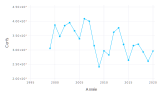

In [ ]:
set_default_plot_size(16cm, 10cm)
df_recolte_annuelle = combine(groupby(recolte, :Année), :Cerfs => sum => :Cerfs)
plot(df_recolte_annuelle, x=:Année, y=:Cerfs, Geom.line, Geom.point)

#### 3.1.2. Quantité de cerfs récoltés annuellement dans toutes les zones par engin
Nous y ajouterons aussi une régression linéaire simple afin de voir la corrélation.

In [ ]:
engins = groupby(recolte, :Engin)  # On groupe les données par engin

df_engin = DataFrame(Année = Int64[], Engin = String[], Cerfs= Int64[])  # On initialise un DataFrame vide

for engin in engins  # Pour chaque engin de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(engin, :Année), :Cerfs => sum => :Cerfs)  
    
    df2 = DataFrame(Année = df.Année, 
                    Engin = fill(unique(engin.Engin)[1], size(df, 1)),
                    Cerfs = df.Cerfs) 
    
    append!(df_engin, df2)  # On ajoute l'information au DataFrame préinitialisé 
end

sort!(df_engin, :Année)
first(df_engin, 5)  

5×3 DataFrame
 Row │ Année  Engin        Cerfs 
     │ Int64  String       Int64 
─────┼───────────────────────────
   1 │  1999  Arc           2463
   2 │  1999  Carabine     26775
   3 │  1999  Indéterminé     20
   4 │  1999  ACB           1329
   5 │  2000  Arc           3246

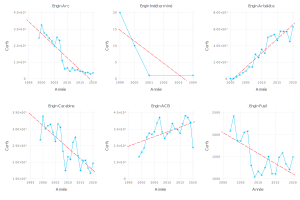

In [ ]:
engins = groupby(df_engin, :Engin)

pp = Plot[]
set_default_plot_size(16cm, 10cm)

r2_values = []

for engin in engins
    fm = @formula(Cerfs ~ Année)
    linearRegressor = lm(fm, engin)
    coefs = GLM.coef(linearRegressor)
    push!(r2_values, r2(linearRegressor))

    p = plot(engin, x=:Année, y=:Cerfs, Geom.point, Geom.line, Guide.title("Engin $(engin.Engin[1])"),
            intercept=[coefs[1]], slope=[coefs[2]], Geom.abline(style=:dash, color="red"))
    push!(pp, p)
end
# Pour afficher les 6 engins 
p = reshape(pp, (2,3))

set_default_plot_size(30cm, 20cm)
gridstack(p)

In [ ]:
for i = 1:length(r2_values)
    println("La corrélation nombre de cerfs/année pour l'engin ", engins[i].Engin[1], " est de ", r2_values[i])
end

La corrélation nombre de cerfs/année pour l'engin Arc est de 0.8328665654594078
La corrélation nombre de cerfs/année pour l'engin Carabine est de 0.6538108153427074
La corrélation nombre de cerfs/année pour l'engin Indéterminé est de 0.6414053426248548
La corrélation nombre de cerfs/année pour l'engin ACB est de 0.30808284933095387
La corrélation nombre de cerfs/année pour l'engin Arbalète est de 0.916088726884003
La corrélation nombre de cerfs/année pour l'engin Fusil est de 0.4019760645518612


On peut voir des corrélations forte entre l'année et le nombre de cerfs récoltés selon les différents types d'engin. Nous vérifierons donc si cela s'applique lorsque séparé par zone.

#### 3.1.3. Par zone : Quantité de cerfs récoltés annuellement
Nous commencerons par visualiser le nombre de cerfs récoltés annuellement par zone.

In [ ]:
zones = groupby(recolte, :Zone)  # On groupe les données par zone

df_zones = DataFrame(Année = Int64[], Zone = Int64[], Cerfs= Int64[])  # On initialise un DataFrame vide

for zone in zones  # Pour chaque zone de chasse,
    
    # pour chaque année,
    # on additionne le nombre de cerfs récoltés selon les différents engins de chasse
    df = combine(groupby(zone, :Année), :Cerfs => sum => :Cerfs)  
    
    df2 = DataFrame(Année = df.Année, 
                    Zone = fill(unique(zone.Zone)[1], size(df, 1)),
                    Cerfs = df.Cerfs) 
    
    append!(df_zones, df2)  # On ajoute l'information au DataFrame préinitialisé 
end

sort!(df_zones, :Année)
first(df_zones, 5)  

5×3 DataFrame
 Row │ Année  Zone   Cerfs 
     │ Int64  Int64  Int64 
─────┼─────────────────────
   1 │  1999      2    922
   2 │  1999      3   1519
   3 │  1999      4   4890
   4 │  1999      5   2014
   5 │  1999      6   4846

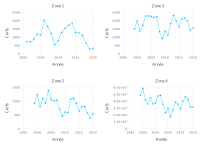

In [ ]:
zones = unique(df_zones[!, :Zone])
pp = Plot[]
set_default_plot_size(16cm, 10cm)
for i = 1:length(zones)
    p = plot(groupby(df_zones, :Zone)[i], x=:Année, y=:Cerfs, Geom.point, Geom.line, Guide.title("Zone $(groupby(df_zones, :Zone)[i].Zone[1])"))
    push!(pp, p)
end
# Pour afficher seulement les 4 premières zones 

p = reshape(pp[1:4], (2,2))

set_default_plot_size(20cm, 15cm)
gridstack(p)

#### 3.1.3. Par zone et engin: Quantité de cerfs récoltés annuellement
Pour visualiser ceci, nous commencerons par

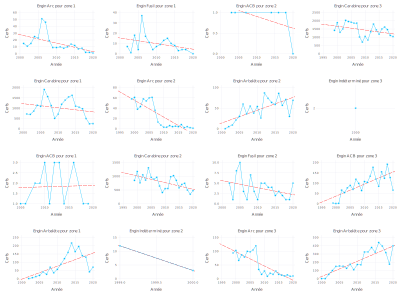

In [ ]:
zones = groupby(sort(recolte,:Zone), :Zone)

df_zone_engin_r2 = DataFrame(Zone = [], Engin = [], r2 = [])

pp = Plot[]
set_default_plot_size(16cm, 10cm)
for zone in zones
    engins = groupby(zone, :Engin)

    r2_values = []

    for engin in engins
        fm = @formula(Cerfs ~ Année)
        linearRegressor = lm(fm, engin)
        coefs = GLM.coef(linearRegressor)
        push!(r2_values, r2(linearRegressor))

        p = plot(engin, x=:Année, y=:Cerfs, Geom.point, Geom.line, Guide.title("Engin $(engin.Engin[1]) pour zone $(engin.Zone[1])"),
            intercept=[coefs[1]], slope=[coefs[2]], Geom.abline(style=:dash, color="red"))
        push!(pp, p)
    end

    df_engin_r2 = DataFrame(
        Zone = fill(unique(zone.Zone)[1], length(r2_values)),
        Engin = unique(zone.Engin),
        r2 = r2_values)

    append!(df_zone_engin_r2, df_engin_r2)

end

# Pour afficher seulement les engins de la zone 1,2 et quelques uns de la 3

p = reshape(pp[1:16], (4,4))

set_default_plot_size(40cm, 30cm)
gridstack(p)

In [ ]:
first(df_zone_engin_r2,5)

5×3 DataFrame
 Row │ Zone  Engin     r2         
     │ Any   Any       Any        
─────┼────────────────────────────
   1 │ 1     Arc       0.305593
   2 │ 1     Carabine  0.0662175
   3 │ 1     Arbalète  0.00105679
   4 │ 1     Fusil     0.441445
   5 │ 1     ACB       0.117232

In [ ]:
for zone in unique(df_zone_engin_r2.Zone)
    println("Pour la zone ",zone)
    filtered = filter(row -> row.Zone == zone, df_zone_engin_r2)
    for row in eachrow(filtered)
        println("La corrélation nombre de cerfs/année pour l'engin ", row.Engin, " est de ", row.r2)
    end
end

Pour la zone 1
La corrélation nombre de cerfs/année pour l'engin Arc est de 0.30559347111128987
La corrélation nombre de cerfs/année pour l'engin Carabine est de 0.06621747866447592
La corrélation nombre de cerfs/année pour l'engin Arbalète est de 0.0010567928294650253
La corrélation nombre de cerfs/année pour l'engin Fusil est de 0.4414450783711972
La corrélation nombre de cerfs/année pour l'engin ACB est de 0.11723231774504783
Pour la zone 2
La corrélation nombre de cerfs/année pour l'engin Arc est de 0.7347805367309476
La corrélation nombre de cerfs/année pour l'engin Carabine est de 0.37849050085865965
La corrélation nombre de cerfs/année pour l'engin Indéterminé est de 1.0
La corrélation nombre de cerfs/année pour l'engin Arbalète est de 0.27673576834485014
La corrélation nombre de cerfs/année pour l'engin Fusil est de 0.496952020287159
La corrélation nombre de cerfs/année pour l'engin ACB est de 0.13509234828496142
Pour la zone 3
La corrélation nombre de cerfs/année pour l'engin 

In [ ]:
first(recolte,5)

5×4 DataFrame
 Row │ Année  Zone   Engin        Cerfs 
     │ Int64  Int64  String15     Int64 
─────┼──────────────────────────────────
   1 │  1999      2  Arc             58
   2 │  1999      2  Carabine       852
   3 │  1999      2  Indéterminé     12
   4 │  1999      3  Arc             94
   5 │  1999      3  Carabine      1422

In [ ]:
first(df_engin,5)

5×3 DataFrame
 Row │ Année  Engin        Cerfs 
     │ Int64  String       Int64 
─────┼───────────────────────────
   1 │  1999  Arc           2463
   2 │  1999  Carabine     26775
   3 │  1999  Indéterminé     20
   4 │  1999  ACB           1329
   5 │  2000  Arc           3246

In [ ]:
#Créer le DataFrame avec zone, engin et linearModels
zones = groupby(sort(recolte,:Zone), :Zone)

df_zone_engin_r2 = DataFrame(Zone = [], Engin = [], models = [])

pp = Plot[]
set_default_plot_size(16cm, 10cm)
for zone in zones
    engins = groupby(zone, :Engin)

    linearModels = []

    for engin in engins
        fm = @formula(Cerfs ~ Année)
        linearRegressor = lm(fm, engin)
        coefs = GLM.coef(linearRegressor)
        push!(linearModels, linearRegressor)

        p = plot(engin, x=:Année, y=:Cerfs, Geom.point, Geom.line, Guide.title("Engin $(engin.Engin[1]) pour zone $(engin.Zone[1])"),
            intercept=[coefs[1]], slope=[coefs[2]], Geom.abline(style=:dash, color="red"))
        push!(pp, p)
    end

    df_engin_r2 = DataFrame(
        Zone = fill(unique(zone.Zone)[1], length(linearModels)),
        Engin = unique(zone.Engin),
        models = linearModels)

    append!(df_zone_engin_r2, df_engin_r2)
end

first(df_zone_engin_r2, 5)

5×3 DataFrame
 Row │ Zone  Engin     models                            
     │ Any   Any       Any                               
─────┼───────────────────────────────────────────────────
   1 │ 1     Arc       TableRegressionModel{LinearModel…
   2 │ 1     Carabine  TableRegressionModel{LinearModel…
   3 │ 1     Arbalète  TableRegressionModel{LinearModel…
   4 │ 1     Fusil     TableRegressionModel{LinearModel…
   5 │ 1     ACB       TableRegressionModel{LinearModel…

In [ ]:

filtered_df = filter(row -> row.Zone == 1, df_zone_engin_r2)
print(filtered_df)

5×3 DataFrame
 Row │ Zone  Engin     models                            
     │ Any   Any       Any                               
─────┼───────────────────────────────────────────────────
   1 │ 1     Arc       TableRegressionModel{LinearModel…
   2 │ 1     Carabine  TableRegressionModel{LinearModel…
   3 │ 1     Arbalète  TableRegressionModel{LinearModel…
   4 │ 1     Fusil     TableRegressionModel{LinearModel…
   5 │ 1     ACB       TableRegressionModel{LinearModel…

In [ ]:
engins = groupby(filtered_df, :Engin)

predictions = []
predict_df = DataFrame(Année = [2020, 2021])

for engin in engins
    predictionsGLM = GLM.predict(engin.models[1],predict_df)
    push!(predictions, predictionsGLM)
end

print(predictions)


Any[Union{Missing, Float64}[3.1857142860317254, 1.9578947371928734], Union{Missing, Float64}[818.4714285766458, 798.5315789531378], Union{Missing, Float64}[1.889519485431606, 1.896329928110184], Union{Missing, Float64}[155.93684210605716, 163.8947368429872], Union{Missing, Float64}[4.413533834537702, 3.869084475841646]]

In [ ]:
prediction2020 = 0
prediction2021 = 0


for engin in predictions
  prediction2020 += engin[1]
  prediction2021 += engin[2]
end
  
print(prediction2020)
print(" , ")
print(prediction2021)


983.897038288704 , 970.1496249372697

In [ ]:
validation2020 = CSV.read("data/validation_2020.csv", DataFrame)
validation2020_zone_1 = filter(row -> row.Zone == 1, validation2020)
print(validation2020_zone_1)

validation2021 = CSV.read("data/validation_2021.csv", DataFrame)
validation2021_zone_1 = filter(row -> row.Zone == 1, validation2021)
print(validation2021_zone_1)


1×2 DataFrame
 Row │ Zone   Cerfs 
     │ Int64  Int64 
─────┼──────────────
   1 │     1    3181×2 DataFrame
 Row │ Zone   Cerfs 
     │ Int64  Int64 
─────┼──────────────
   1 │     1    522

In [ ]:
function getRMSE(prediction::Float64, validation::Float64)
    return sqrt(mean((prediction .- validation.Cerfs).^2))
end

getRMSE (generic function with 3 methods)

In [ ]:
getRMSE(prediction2020,validation2020_zone_1)

665.897038288704

In [ ]:
getRMSE(prediction2021,validation2021_zone_1)

448.14962493726966

In [ ]:
predict_per_zone_2020 = DataFrame(Zone = Int64[], Cerfs= Float64[])
predict_per_zone_2021 = DataFrame(Zone = Int64[], Cerfs= Float64[])

#recolte_without_21 = subset(recolte, :Zone => ByRow(zone -> zone != 21))

#print(recolte_without_21)

for zone in unique(recolte.Zone)
  filtered_df = filter(row -> row.Zone == zone, df_zone_engin_r2)
  engins = groupby(filtered_df, :Engin)

  predictions = []
  predict_df = DataFrame(Année = [2020, 2021])

  for engin in engins
    predictionsGLM = GLM.predict(engin.models[1],predict_df)
    push!(predictions, predictionsGLM)
  end

  prediction2020 = 0
  prediction2021 = 0


  for engin in predictions
    prediction2020 += engin[1]
    prediction2021 += engin[2]
  end

  if zone != 21
    push!(predict_per_zone_2020,[zone prediction2020])
    push!(predict_per_zone_2021,[zone prediction2021])
  end

end


In [ ]:
sort!(predict_per_zone_2020)

18×2 DataFrame
 Row │ Zone   Cerfs      
     │ Int64  Float64    
─────┼───────────────────
   1 │     1   983.897
   2 │     2   419.302
   3 │     3  1762.24
   4 │     4  3125.72
   5 │     5  1814.79
   6 │     6  4105.51
   7 │     7  3113.9
   8 │     8  3167.66
   9 │     9   907.164
  10 │    10  3534.31
  11 │    11   871.954
  12 │    12    13.1512
  13 │    13     7.79985
  14 │    15   159.474
  15 │    20  2957.79
  16 │    26   215.047
  17 │    27   868.661
  18 │    28   137.193

In [ ]:
sort!(predict_per_zone_2021)

18×2 DataFrame
 Row │ Zone   Cerfs      
     │ Int64  Float64    
─────┼───────────────────
   1 │     1   970.15
   2 │     2   385.705
   3 │     3  1757.84
   4 │     4  3064.16
   5 │     5  1813.17
   6 │     6  4058.21
   7 │     7  3124.18
   8 │     8  3198.77
   9 │     9   867.102
  10 │    10  3350.69
  11 │    11   828.786
  12 │    12    12.6874
  13 │    13     7.57112
  14 │    15   151.883
  15 │    20  2786.97
  16 │    26   243.267
  17 │    27   893.327
  18 │    28   152.466

In [ ]:
function getRMSE_df(prediction::DataFrame, validation::DataFrame)
    return sqrt(mean((prediction.Cerfs .- validation.Cerfs).^2))
end

getRMSE_df (generic function with 1 method)

In [ ]:
getRMSE_df(predict_per_zone_2020,validation2020)

484.64930267403946

In [ ]:
getRMSE_df(predict_per_zone_2021,validation2021)

780.0332600122683